In [1]:
from alse.alse_workflow import alse
from alse.utils import read_excel
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch, gpytorch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from botorch.fit import fit_gpytorch_model
from alse.gp_model import fit_gp_model
from alse.eci import ExpectedCoverageImprovement
from alse.utils import normalize, unnormalize
from botorch.optim import optimize_acqf
import copy
from botorch.sampling.samplers import SobolQMCNormalSampler

In [2]:
y_name = ["width (mm)", "powder_cap", "wth"]
x_name = ["V (mm/min)", "P (W)"]
bounds = torch.tensor([[600, 900], [1800, 2700]])
constraints = [("gt", 2.5), ("gt", 50), ("gt", 6)]
X, width, pow_cap, wth = read_excel("../test_data/8_4_data.xlsx", x_name, y_name)

d:\Python310\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
d:\Python310\lib\site-packages\gpytorch\

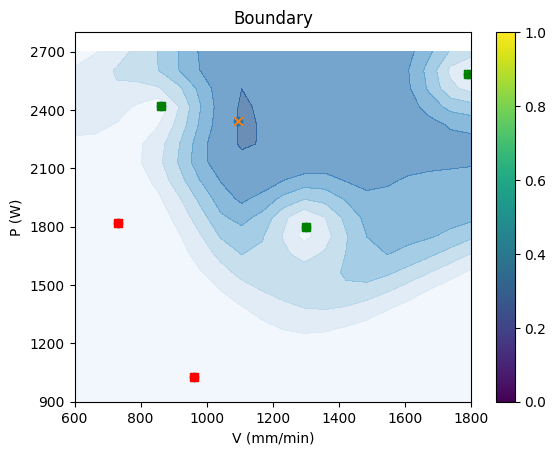

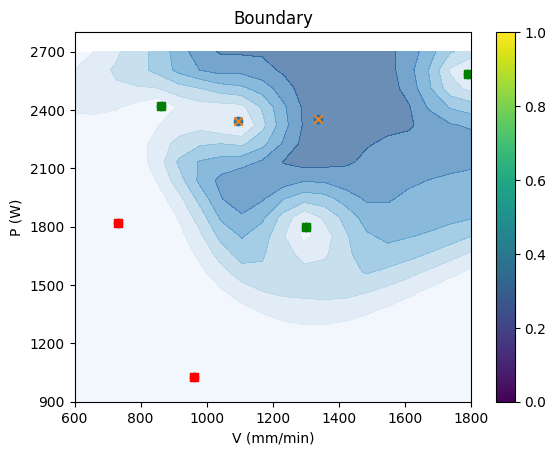

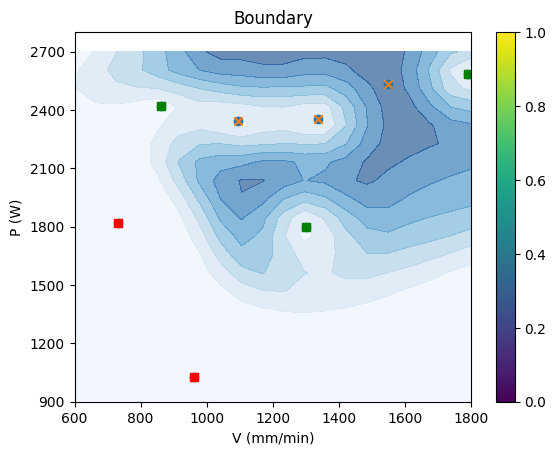

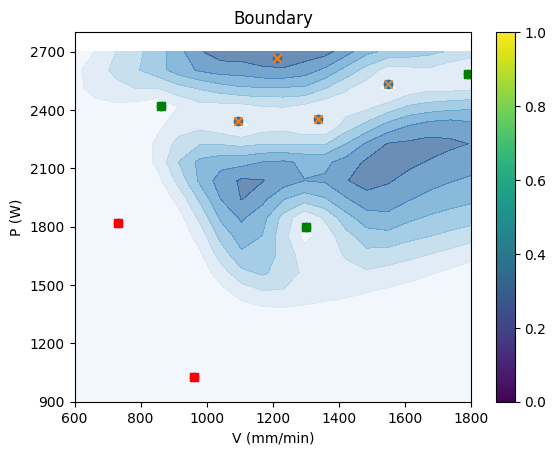

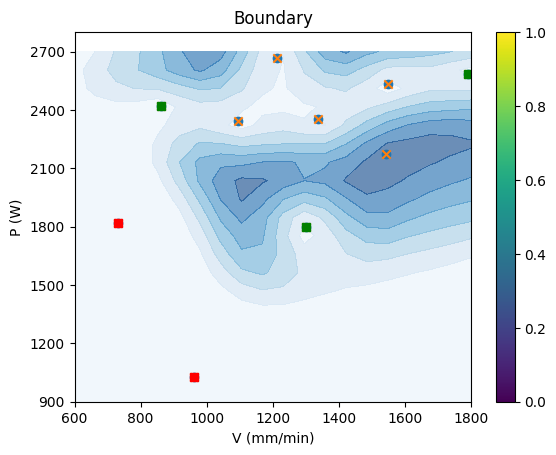

In [3]:
timestep = [5]

for ts in timestep:
    Xall, width, pow_cap, wth = read_excel("../test_data/8_4_data.xlsx", x_name, y_name)
    y_name_plt = ["Width (mm)", "Powder Capture (%)", "Width-to-Height Ratio"]

    X=Xall[:ts, :]
    width=width[:ts]
    pow_cap=pow_cap[:ts]
    wth=wth[:ts]
    radius = 0.1
    algo = alse(X, bounds, [width, pow_cap, wth], constraints, punchout_radius = radius)
    # print(X)
    algo.initialize_model(["reg", "reg", "reg"])

    resolution = 20
    y_predict = algo.get_posterior_grid(resolution)

    [*Xplt] = torch.meshgrid(
        [torch.linspace(bounds[0][i], bounds[1][i], resolution) for i in range(2)],
        indexing="xy",
    )
    constraint_dp, overlap_dp = algo.get_points_mask([width, pow_cap, wth])
    
    for _ in range(5):
        plt.figure()
        overlap = algo.get_acq_val_grid().detach().numpy()
        new_next = algo.next_test_points()
        train_x_temp = algo.normalized_x.clone().detach()
        train_y_temp = algo.train_y.copy()
        # train_x_temp = torch.cat((train_x_temp, normalize(new_next.float(), bounds)))
        
        list_of_models_temp = algo.list_of_models.copy()
        model_list = ModelListGP(*[model for model in list_of_models_temp])
        
        plt.contourf([*Xplt][0], [*Xplt][1], overlap.reshape(resolution,resolution), cmap="Blues", alpha=0.6)
        plt.plot(X[~overlap_dp, 0], X[~overlap_dp, 1], "sr", label="Out of Boundary")
        plt.plot(X[overlap_dp, 0], X[overlap_dp, 1], "sg", label="In Boundary")
        
        plt.scatter(unnormalize(train_x_temp, bounds)[:,0], unnormalize(train_x_temp, bounds)[:,1], marker= 'o')
        plt.scatter(new_next[:,0], new_next[:,1], marker= 'x')
        plt.xlabel(x_name[0])
        plt.ylabel(x_name[1])
        plt.xlim(600, 1800)
        plt.ylim(900, 2800)
        plt.yticks(np.arange(900,3000, 300))
        plt.colorbar()
        plt.title("Boundary")

        algo = alse(unnormalize(train_x_temp, bounds), bounds, train_y_temp, constraints, punchout_radius = radius)

        algo.initialize_model(["reg", "reg", "reg"])